Importaciones

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing as skp
import sounddevice as sd

Adaline

In [2]:
class AdalineMultiOutput:
    def __init__(self, input_size, output_size=3, learning_rate=0.001, epochs=100):
        """
        Initializes the ADALINE network with multiple outputs.

        Parameters:
        - input_size: Number of input features (excluding the bias).
        - output_size: Number of outputs (signals to recover).
        - learning_rate: Learning rate for weight updates.
        - epochs: Number of iterations over the training set.
        """
        self.weights = np.zeros((output_size, input_size + 1))
        self.learning_rate = learning_rate
        self.epochs = epochs

        self.errors = []

    def predict(self, x):
        """
        Makes a prediction for a single input sample.

        Parameters:
        - x: Input vector.

        Returns:
        - Predicted output vector.
        """
        x = np.insert(x, 0, 1)

        return np.dot(self.weights, x)

    def train(self, X, D):
        """
        Trains the ADALINE network using the provided dataset.

        Parameters:
        - X: Input matrix (n_samples, input_size).
        - D: Desired output matrix (n_samples, output_size).
        """
        for epoch in range(self.epochs):
            mse_ = 0

            for i in range(len(X)):
                x_i = np.insert(X[i], 0, 1) 
                y = np.dot(self.weights, x_i)  
                error = D[i] - y  
                mse_ += np.sum(error ** 2)
                self.weights += 2 * self.learning_rate * np.outer(error, x_i)
            self.errors.append(np.mean(mse_))

            if (epoch + 1) % 20 == 0:
                y_pred = self.predict_batch(X)
                mse = np.mean((D - y_pred) ** 2)
                self.errors.append(mse)
                print(f"Epoch {epoch + 1}/{self.epochs} - MSE: {mse:.5f}")

    def predict_batch(self, X):
        """
        Makes predictions for a batch of input samples.

        Parameters:
        - X: Input matrix (n_samples, input_size).

        Returns:
        - Predicted output matrix (n_samples, output_size).
        """
        X_bias = np.insert(X, 0, 1, axis=1)
        return np.dot(X_bias, self.weights.T)

Record Audios

In [19]:
duration = 6
sample_rate = 44100
num_sounds = 3

def record_audio(duration, sample_rate):
    print("Recording...")
    audio = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=1)
    sd.wait()
    print("Recording finished")    
    return audio

def get_audios(num_sounds, duration, sample_rate):

    sounds_recorded = []
    for i in range(num_sounds):
        print(f"Recording audio {i + 1}")
        sounds_recorded.append(record_audio(duration, sample_rate))
        sd.wait()

        if i != num_sounds - 1:
            print(f"Audio {i + 1} recorded")
        else:
            print("Audios recorded")
        sd.wait()

    return np.array(sounds_recorded)

created_audios = get_audios(num_sounds, duration, sample_rate)

Recording audio 1
Recording...
Recording finished
Audio 1 recorded
Recording audio 2
Recording...
Recording finished
Audio 2 recorded
Recording audio 3
Recording...
Recording finished
Audios recorded


Normalización de los Audios

In [20]:
scale = skp.MinMaxScaler(feature_range=(0, 1))

audio_1 = np.array([item for sublist in created_audios[0] for item in sublist])
audio_2 = np.array([item for sublist in created_audios[1] for item in sublist])
audio_3 = np.array([item for sublist in created_audios[2] for item in sublist])

normalized_audio_1 = scale.fit_transform(audio_1.reshape(-1,1)).flatten()
normalized_audio_2 = scale.fit_transform(audio_2.reshape(-1,1)).flatten()
normalized_audio_3 = scale.fit_transform(audio_3.reshape(-1,1)).flatten()

Entrenamiento

In [22]:
delay = 20
sound_lenght = (duration * sample_rate)

noisy_audios = normalized_audio_1 + normalized_audio_2 + normalized_audio_3
X = np.array([noisy_audios[i : i + delay] for i in range( sound_lenght - delay )])

delay_audio_1 = normalized_audio_1[delay:]
delay_audio_2 = normalized_audio_2[delay:]
delay_audio_3  = normalized_audio_3[delay:]

D = np.stack((delay_audio_1, delay_audio_2, delay_audio_3), axis=1)

output_size=3
learning_rate=0.0001
epochs= 80
adaline = AdalineMultiOutput(delay, output_size, learning_rate, epochs)
adaline.train(X, D)

Epoch 20/80 - MSE: 0.00156
Epoch 40/80 - MSE: 0.00154
Epoch 60/80 - MSE: 0.00154
Epoch 80/80 - MSE: 0.00153


Extracción de las señales

In [23]:
prediction = adaline.predict_batch(X)
prediction_signal_1 = prediction[:, 0]
prediction_signal_2 = prediction[:, 1]
prediction_signal_3  = prediction[:, 2]

Gráfica del Error

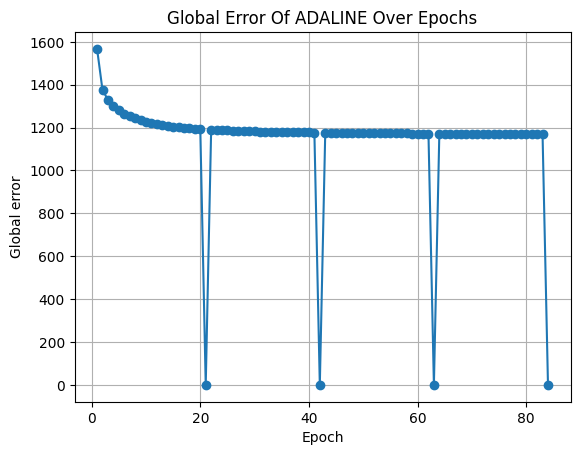

In [25]:
plt.figure()
plt.plot(range(1, len(adaline.errors) + 1), adaline.errors, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Global error')
plt.title('Global Error Of ADALINE Over Epochs')
plt.grid(True)

Comparación entre Predicciones y Señales Originales

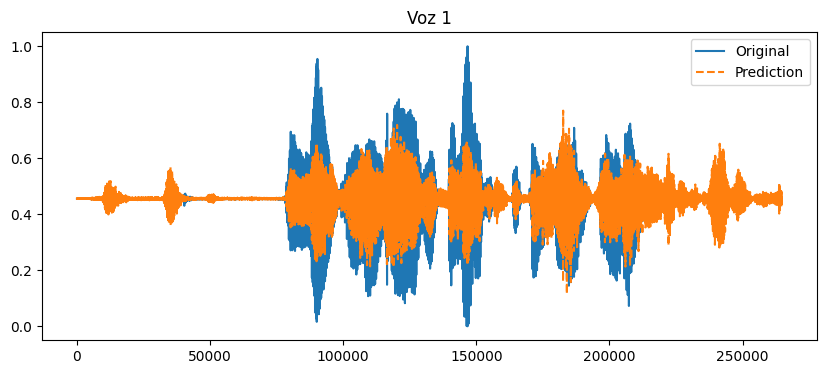

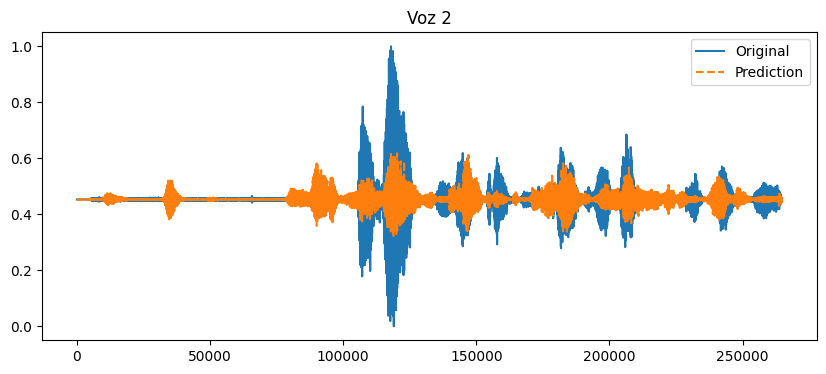

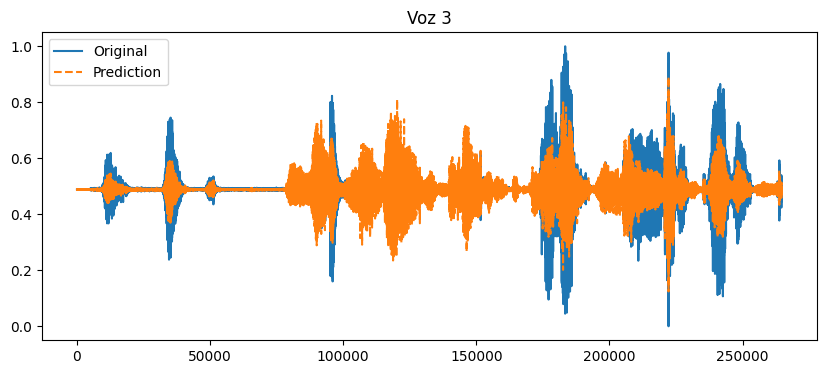

In [26]:
def graficar_senal(original, predictions, title):
    plt.figure(figsize=(10, 4))
    plt.plot(original, label="Original")
    plt.plot(predictions, label="Prediction", linestyle='--')
    plt.title(title)
    plt.legend()
    plt.show()

# Graficar las señales
graficar_senal(normalized_audio_1, prediction_signal_1, "Voz 1")
graficar_senal(normalized_audio_2, prediction_signal_2, "Voz 2")
graficar_senal(normalized_audio_3, prediction_signal_3, "Voz 3")

Valor de Correlación entre los Audios

In [27]:
correlation_audio_1 = np.corrcoef(delay_audio_1, prediction_signal_1)[0, 1]
print("Correlation audio 1: ", correlation_audio_1)

correlation_audio_2 = np.corrcoef(delay_audio_2, prediction_signal_2)[0, 1]
print("Correlation audio 2: ",correlation_audio_2)

correlation_audio_3 = np.corrcoef(delay_audio_3, prediction_signal_3)[0, 1]
print("Correlation audio 3: ",correlation_audio_3)

Correlation audio 1:  0.7284349001425974
Correlation audio 2:  0.47894169107758366
Correlation audio 3:  0.6004096072623774
